#### Imports

In [1]:
import os, sys, copy
sys.path.append('..')
import time
import warnings
warnings.filterwarnings("ignore")

import collections as coll
import itertools as it
import functools as ft

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
from IPython.display import display

import cv2
import trackpy as tp
from PIL import Image

from src.capture import LazyCapture
from src.frames import cast, select_channel, plicate_channel, remove_borders, remove_outside_petri, annotate, average
from src.labels import load_labels, map_labels, l2arr, l2i, larr2i
from src.debug import print_frame, carrousel
from src.augmentation import h_mirror_frame, h_mirror_label, v_mirror_frame, v_mirror_label, rotate_90_frame, rotate_90_label,\
    rotate_180_frame, rotate_180_label, rotate_270_frame, rotate_270_label
from src.evaluation import evaluate, custom_accuracy, distance

## Harcoded

#### Load raw data

In [2]:
captures = [
    LazyCapture.load('../data/pw1_A1_0315_part1.avi'),
    LazyCapture.load('../data/pw1_A1_0315_part2.avi'),
    LazyCapture.load('../data/pw1_A1_0315_part3.avi')
]

labels = [
    load_labels('../data/pw1_A1_0315_part1.txt'),
    load_labels('../data/pw1_A1_0315_part2.txt'),
    load_labels('../data/pw1_A1_0315_part3.txt')
]

##### Apply basic transformations

In [3]:
reverse = False

for capture in captures:
    w, h = capture.W(), capture.H()
    capture.apply(select_channel(1), shape=(w, h, 1), reverse=reverse)
    capture.apply(remove_outside_petri((w//2, h//2), (w//2 - 20, h//2 - 20)), reverse=reverse)
    #capture.apply(remove_borders(20, hard=True), shape=(w-40, h-40, 1), reverse=reverse)

for i in range(len(labels)):
    labels[i] = map_labels(labels[i], lambda l: l2arr(l)) # - 20

CW, CH = captures[0].W(), captures[0].H()

#### Target capture and labels

In [4]:
cap, cap_final = captures[0].clone(), captures[0].clone()
#cap.apply(h_mirror_frame)

lab = labels[0]
#lab = map_labels(lab, lambda l: h_mirror_label(0, l, (cap.W(), cap.H())))

#### CV2

In [5]:
# Removed from background_subtraction: frame = cv2.morphologyEx(frame, cv2.MORPH_CLOSE, np.ones((11,11), np.uint8))

def background_subtraction(i, frame, acc):
    frame = acc.apply(frame[:, :, 0])
    frame = cv2.blur(frame, (5, 5))
    return frame[:, :, np.newaxis], acc

background_subtractor = cv2.createBackgroundSubtractorMOG2(history=300, varThreshold=32, detectShadows=False)
background_subtractor.setNMixtures(2)

cap.apply(background_subtraction, acc=background_subtractor)

#### Trackpy

In [6]:
options = {
    "minmass": 40, #50
    "maxsize": None,
    "separation": 50, # 10
    "noise_size": 1,
    "smoothing_size": None,
    "threshold": 1,
    "invert": False,
    "percentile": 70, # 70
    "topn": 5, # 10
    "preprocess": False,
    "max_iterations": 10, # 20
    "characterize": False # True
}

In [7]:
# Apply locate to every frame
locations_list = []

for i, frame in cap.frames():
    locations = tp.locate(frame[:, :, 0], 9, **options)
    locations['frame'] = i
    locations_list.append(locations)

full_locations = pd.concat(locations_list)

Frame 2980: 1 trajectories present.


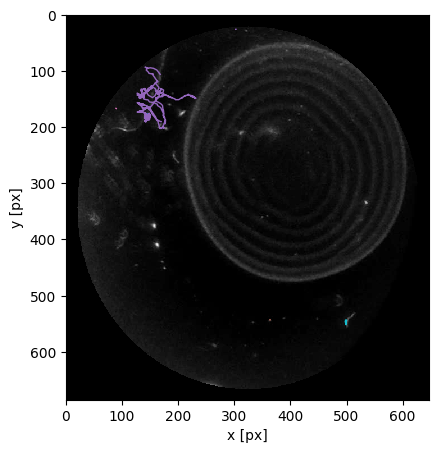

<AxesSubplot: xlabel='x [px]', ylabel='y [px]'>

In [8]:
trajectories = tp.link(full_locations, 25, memory=50)
tp.plot_traj(trajectories, superimpose=captures[0].frame(0, index=False)[1])

#### Select trajectory

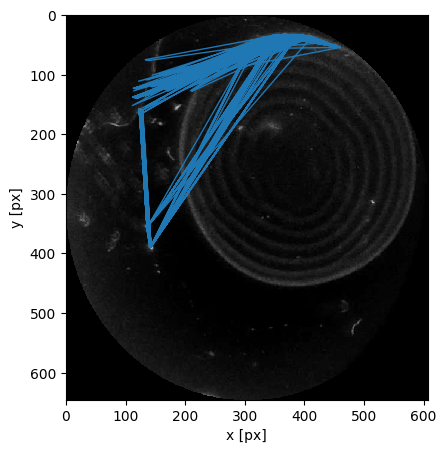

<AxesSubplot: xlabel='x [px]', ylabel='y [px]'>

In [8]:
# 0
trajectories_filtered = trajectories.sort_values(['frame', 'mass'], ascending=[True, False]).drop_duplicates('frame')
trajectories_filtered['particle'] = 0
tp.plot_traj(trajectories_filtered, superimpose=captures[0].frame(0, index=False)[1])

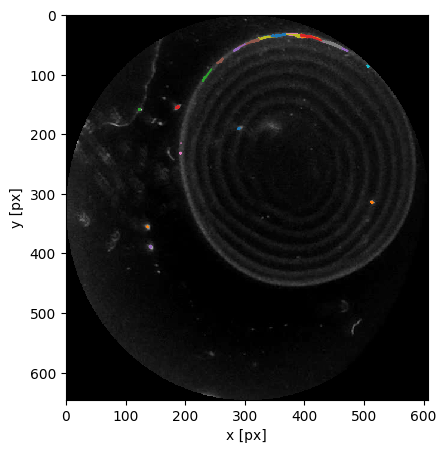

<AxesSubplot: xlabel='x [px]', ylabel='y [px]'>

In [9]:
# A
particles = trajectories['particle'].value_counts()
trajectories_filtered = trajectories[trajectories['particle'].isin(particles[particles > 50].index)]
tp.plot_traj(trajectories_filtered, superimpose=captures[0].frame(0, index=False)[1])

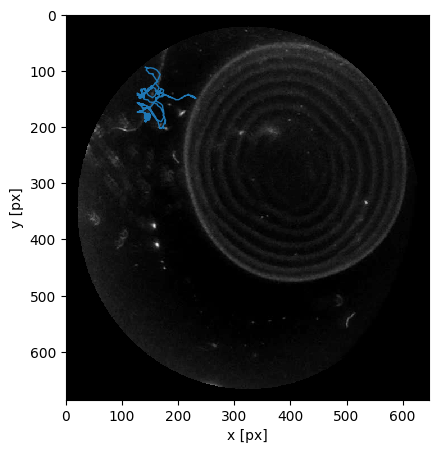

<AxesSubplot: xlabel='x [px]', ylabel='y [px]'>

In [9]:
# B
particles = trajectories['particle'].value_counts()
relevant_particles = particles[particles > 200]
trajectories_filtered = trajectories.merge(relevant_particles, how='inner', left_on='particle', right_index=True)
trajectories_filtered = trajectories_filtered.sort_values(['frame', 'particle_y'], ascending=[True, False]).drop_duplicates('frame')
trajectories_filtered['particle'] = 0
tp.plot_traj(trajectories_filtered, superimpose=captures[0].frame(0, index=False)[1])
#best_particle = trajectories.groupby('frame').filter(lambda x: )

#### Fill trajectory

In [10]:
full_trajectories = trajectories_filtered.set_index('frame').reindex(np.arange(cap.length())).reset_index().ffill()

#### Extract labels

In [22]:
labels_predicted = {int(row['frame']): np.array([row['x'], row['y']]) for _, row in full_trajectories.iterrows()}

In [23]:
with open('out.txt', 'w') as file:
    file.write("frame;x;y\n")
    file.writelines(["{};{:.2f};{:.2f}\n".format(f, x, y) for f, (x, y) in labels_predicted.items()])

#### Evaluate

In [12]:
# Evaluate 
acc = evaluate(lab, labels_predicted, custom_accuracy(7, 10))
dist = evaluate(lab, labels_predicted, distance())
acc, dist

((2539, 0.9970460811343048), (2539, 1.467605796419972))

#### Carrousel

In [15]:
cap_final.apply(plicate_channel(3), shape=(cap.W(), cap.H(), 3))
cap_final.apply(annotate(map_labels(lab, larr2i)))
cap_final.apply(annotate(map_labels(labels_predicted, larr2i), color=[0, 255, 0]))
carrousel(it.islice(cap_final.frames(), 0, cap_final.length(), 20))

## Functions